### Binomial Asset Price Modelling

Will treat a binomial tree as a network with nodes $(i,j)$, with $i$ representing the time steps and $j$ the number of up moves. The number of down moves is $i-j$.

- The price of the asset at node $(i,j)$ is $S_{i,j} = S_0u^jd^{i-j}$, where $u$ and $d$ are the up and down factors, respectively.
- The Option price at node $(i,j)$ is $C_{i,j}, where $C_{N,j}$ represents the payoff of the option at maturity.

> For an European call option, the payoff is $C_{N,j} = \max(S_{N,j} - K, 0)$, where $K$ is the strike price.

In [1]:
# Generic timing wrapper function
from functools import wraps
from time import time

def timing(f):
	@wraps(f)
	def wrapper(*args, **kwargs):
		start = time()
		result = f(*args, **kwargs)
		end = time()
		print(f'Elapsed time: {end-start:.6f} seconds')
		return result
	return wrapper

#### Binomial tree (loop version)

In [35]:
import numpy as np

@timing
def binomial_tree(S0, K, T, r, N, u, d, option_type):
    dt = T / N                              # Time step
    p = (np.exp(r * dt) - d) / (u - d)      # Risk-neutral probability
    disc = np.exp(-r * dt)                  # Discount factor
    bin_tree = np.zeros((N + 1, N + 1))		# Initialise the tree
    # Fill the tree
    for j in range(N + 1):                  #
        bin_tree[N, j] = max(S0 * u ** j * d ** (N - j) - K, 0)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            bin_tree[i, j] = disc * (p * bin_tree[i + 1, j + 1] + (1 - p) * bin_tree[i + 1, j])
    return bin_tree
binomial_tree(S0, K, T, r, N, u, d, option_type)

Elapsed time: 0.000000 seconds


array([[10.1457358 ,  0.        ,  0.        ,  0.        ],
       [ 3.25450292, 15.44712278,  0.        ,  0.        ],
       [ 0.        ,  5.70482508, 22.98013267,  0.        ],
       [ 0.        ,  0.        , 10.        , 33.1       ]])

In [52]:
import numpy as np

@timing
def binomial_tree_slow(S0, K, T, r, N, u, d, option_type):
    dt = T / N                              # Time step
    q = (np.exp(r * dt) - d) / (u - d)      # Risk-neutral probability
    disc = np.exp(-r * dt)                  # Discount factor

    # initialize asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0 * d**N
    for i in range(1, N+1):
        S[i] = S[i-1] * u/d

    # initialize option values at maturity - Time step N
    C = np.zeros(N+1)
    for i in range(N+1):
        C[i] = max(S[i] - K, 0) # Call option

    # step back through the tree
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            C[j] = disc * (q * C[j+1] + (1-q) * C[j])

    return C[0]

# Initial parameters
S0 = 100    # Initial price of the asset
K = 100     # Strike price
T = 1/3       # time to maturity in years
r = 0.1   # annual risk-free rate
N = 4     # number of time steps
u = 1.0604     # up factor
d = 1/u     # down factor (divided by u)
option_type = 'call'
binomial_tree_slow(S0, K, T, r, N, u, d, option_type)

Elapsed time: 0.000000 seconds


6.136931812319602

In [53]:
import numpy as np
def binomial_tree_vectorized(S0, K, T, r, N, u, d, option_type):
	dt = T/N
	q = (np.exp(r * dt) - d) / (u - d)
	disc = np.exp(-r * dt)

	S = S0 * u**np.arange(N, -1, -1) * d **np.arange(N+1)

	# Option values at maturity
	if option_type == "call":
	    C = np.maximum(S - K, 0)
	elif option_type == "put":
	    C = np.maximum(K - S, 0)
	else:
	    raise ValueError("Invalid option type. Choose 'call' or 'put'.")

	for _ in np.arange(N):
	    C = disc * (q * C[:-1] + (1 - q) * C[1:])

	return C[0]

binomial_tree_vectorized(S0, K, T, r, N, u, d, option_type)

6.1369318123196175

In [78]:
def american_option(asset, volatility, int_rate, strike, expiry, no_steps):
    # Time step
    time_step = expiry / no_steps

    # Discount factor
    discount_factor = np.exp(-int_rate * time_step)

    # Up and down factors
    temp1 = np.exp((int_rate + volatility ** 2) * time_step)
    temp2 = 0.5 * (temp1 - discount_factor)
    u = temp2 + np.sqrt(temp2 ** 2 + discount_factor)
    d = (np.exp(int_rate * time_step) * discount_factor) / u

    # Probability
    p = (np.exp(int_rate * time_step) - d) / (u - d)

    # Initialize stock price and option value arrays
    S = np.zeros(no_steps + 1)
    V = np.zeros(no_steps + 1)

    # Stock prices at maturity
    for j in range(no_steps + 1):
        S[j] = asset * (u ** j) * (d ** (no_steps - j))

    # Option value at maturity (payoff)
    for j in range(no_steps + 1):
        V[j] = max(S[j] - strike, 0)  # For a call option. Use (strike - S[j]) for a put option.

    # Backward induction through the tree
    for n in range(no_steps - 1, -1, -1):
        for j in range(n + 1):
            S[j] = S[j] / u
            V[j] = max((p * V[j + 1] + (1 - p) * V[j]) * discount_factor, max(S[j] - strike, 0))

    # Return the option price at the root of the tree
    return V[0]

# Example usage
asset = 100  # Current stock price
volatility = 0.2  # Annual volatility
int_rate = 0.06  # Annual risk-free rate
strike = 100  # Strike price
expiry = 1  # Time to expiry in years
no_steps = 3  # Number of steps in the binomial tree

price = american_option(asset, volatility, int_rate, strike, expiry, no_steps)
print(f"The price of the American option is: {price}")


The price of the American option is: 5.858946526464091


In [80]:
import numpy as np

def european_option_price(S0, sigma, r, K, T, N, option_type):
    # Time step
    dt = T / N

    # Discount factor
    disc = np.exp(-r * dt)

    # Up and down factors
    temp1 = np.exp((r + sigma ** 2) * dt)
    temp2 = 0.5 * (temp1 + disc)
    u = temp2 + np.sqrt(temp2 ** 2  - 1)
    d = 1 / u

    # Probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Stock prices at maturity
    num_steps = np.arange(N + 1)
    S = S0 * (u ** num_steps) * (d ** (N - num_steps))

    V = np.maximum(S - K, 0) if option_type == "call" else np.maximum(K - S, 0)

    # Backward induction
    for n in range(N - 1, -1, -1):
    # for _ in np.arange(N):
        V[:n + 1] = (p * V[1:n + 2] + (1 - p) * V[:n + 1]) * disc
        # V = (p * V[:-1] + (1 - p) * V[1:]) * disc

    # Option price at the root
    return V[0]

# Example usage
asset = 100             # Current stock price
volatility = 0.2        # Annual volatility
int_rate = 0.1          # Annual risk-free rate
strike = 100            # Strike price
expiry = 1/3            # Time to expiry in years
no_steps = 4            # Number of steps in the binomial tree
option_type = "call"    # "call" or "put"

price = european_option_price(asset, volatility, int_rate, strike, expiry, no_steps, option_type)
print(f"The price of the European {option_type} option is: {price}")


The price of the European call option is: 6.134472467975938


In [41]:
import numpy as np
def american_option_price(asset, sigma, r, K, T, N, option_type):
    # Time step
    dt = T / N

    # Discount factor
    disc = np.exp(-r * dt)

    # Up and down factors
    temp1 = np.exp((r + sigma ** 2) * dt)
    temp2 = 0.5 * (temp1 + disc)
    u = temp2 + np.sqrt(temp2 ** 2  - 1)
    d = 1 / u

    # Probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Generate stock prices at maturity
    j = np.arange(N + 1)
    S = asset * (u ** j) * (d ** (N - j))

    payoff = (S - K) if option_type == "call" else (K - S)
    v_mat = np.maximum(payoff, 0)

    V = np.zeros((N + 1, N + 1))
    V[:,-1] = v_mat

    # Backward induction through the tree
    for n in range(N - 1, -1, -1):
        S = S[:-1] / d  # Adjust stock prices for the previous step
        start_idx = N - n
        end_idx = -N-1+n

        disc_value = (          p * V[start_idx:, n+1] + (1 - p) * V[start_idx-1:-1, n+1]) * disc
        # Calculate payoff based on option type
        payoff = (S - K) if option_type == "call" else (K - S)

        # Update option values
        V[start_idx:, end_idx] = np.maximum(disc_value, np.maximum(payoff, 0))

    # Return the option price in a triangular superior matrix
    return V[::-1]

# Example usage
asset = 100             # Current stock price
volatility = 0.2        # Annual volatility
int_rate = 0.1          # Annual risk-free rate
strike = 100            # Strike price
expiry = 1/3              # Time to expiry in years
no_steps = 4           # Number of steps in the binomial tree
option_type = "call"    # "call" or "put"

price = american_option_price(asset, volatility, int_rate, strike, expiry, no_steps, option_type)
print(f"The price of the American {option_type} option is: {price[0,0]}")


KeyboardInterrupt: 

In [75]:
import numpy as np
def binomial_recomb_uptriang(a, n):
    # Create a grid of indices for powers
    rows, cols = np.triu_indices(n + 1)

    # Compute terms for (a + 1/a)^n
    terms = a ** ((cols - rows) + (np.sort(rows - cols)[::-1]))

    # Create an upper diagonal matrix
    matrix = np.zeros((n + 1,  n + 1))
    matrix[rows, cols] = terms
    return  matrix


def american_option_price(S0, sigma, r, K, T, N, option_type):
    # Time step
    dt = T / N

    # Discount factor
    disc = np.exp(-r * dt)

    # Up and down factors
    temp1 = np.exp((r + sigma ** 2) * dt)
    temp2 = 0.5 * (temp1 + disc)
    u = temp2 + np.sqrt(temp2 ** 2  - 1)
    d = 1 / u

    # Probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Generate stock prices
    S = S0 * binomial_recomb_uptriang(u, N)

    # Calculate payoff based on option type
    payoff = (S - K) if option_type == "call" else (K - S)
    opt_val = np.maximum(payoff, 0)

    # Initialize option values at maturity
    V = np.zeros((N + 1, N + 1))
    V[:,-1] = opt_val[:,-1]

    # Backward induction through the tree
    for n in range(N):
        col = N - n
        # Calculate the discounted value
        disc_value = (p * V[:col, col] + (1 - p) * V[1 : col+1, col]) * disc

        # Update option values
        V[:col, col-1] = np.maximum(disc_value, opt_val[:col, col-1])
    return V

# Example usage
asset = 100             # Current stock price
volatility = 0.2        # Annual volatility
int_rate = 0.1          # Annual risk-free rate
strike = 100            # Strike price
expiry = 1/3              # Time to expiry in years
no_steps = 4         # Number of steps in the binomial tree
option_type = "call"    # "call" or "put"

price = american_option_price(asset, volatility, int_rate, strike, expiry, no_steps, option_type)
print(f"The price of the American {option_type} option is: {price[0,0]}")


The price of the American call option is: 6.134472467975936


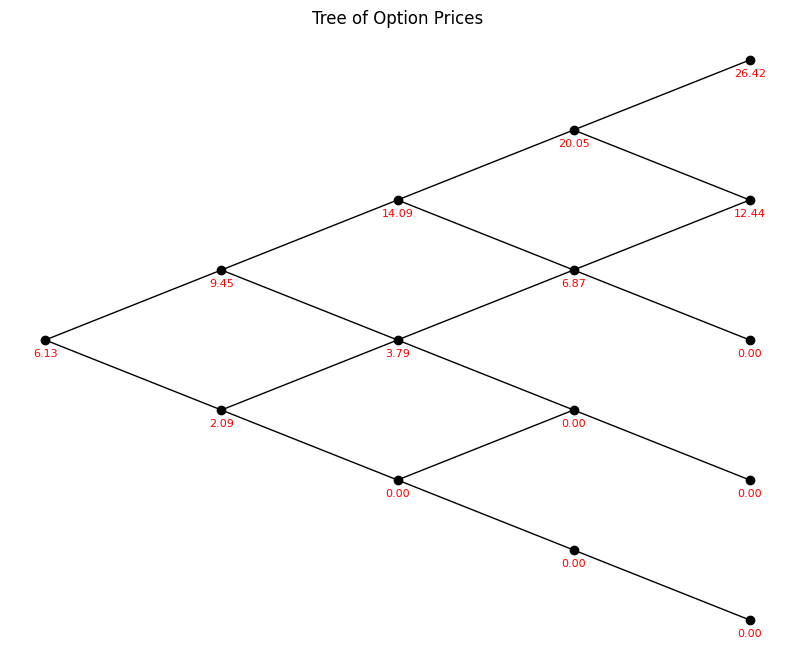

In [90]:
import matplotlib.pyplot as plt

# Define node positions and values with evenly spaced y-coordinates
nodes = {
    (0, 0): 6.13,
    (1, 1): 2.09, (1, -1): 9.45,
    (2, 2): 0.00, (2, 0): 3.79, (2, -2): 14.09,
    (3, 3): 0.00, (3, 1): 0.00, (3, -1): 6.87, (3, -3): 20.05,
    (4, 4): 0.00, (4, 2): 0.00, (4, 0): 0.00, (4, -2): 12.44, (4, -4): 26.42,
}

# Create a list of edges (connections between nodes)
edges = [
    ((0, 0), (1, 1)), ((0, 0), (1, -1)),
    ((1, 1), (2, 2)), ((1, 1), (2, 0)),
    ((1, -1), (2, 0)), ((1, -1), (2, -2)),
    ((2, 2), (3, 3)), ((2, 2), (3, 1)),
    ((2, 0), (3, 1)), ((2, 0), (3, -1)),
    ((2, -2), (3, -1)), ((2, -2), (3, -3)),
    ((3, 3), (4, 4)), ((3, 1), (4, 2)),
    ((3, -1), (4, 0)), ((3, -1), (4, -2)),
    ((3, -3), (4, -2)), ((3, -3), (4, -4)),
]

# Initialize the plot
plt.figure(figsize=(10, 8))

# Draw edges
for edge in edges:
    x0, y0 = edge[0]
    x1, y1 = edge[1]
    plt.plot([x0, x1], [y0, y1], 'k-', lw=1)  # 'k-' means black lines

# Draw nodes and labels
for position, value in nodes.items():
    x, y = position
    plt.plot(x, y, 'ko')  # Draw nodes as black circles
    plt.text(x, y + 0.2, f'{value:.2f}', ha='center', va='center', fontsize=8, color='red')  # Move text above nodes

# Adjust plot aesthetics
plt.title("Tree of Option Prices")
plt.gca().invert_yaxis()  # Optional: Remove this if you prefer normal y-axis
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()


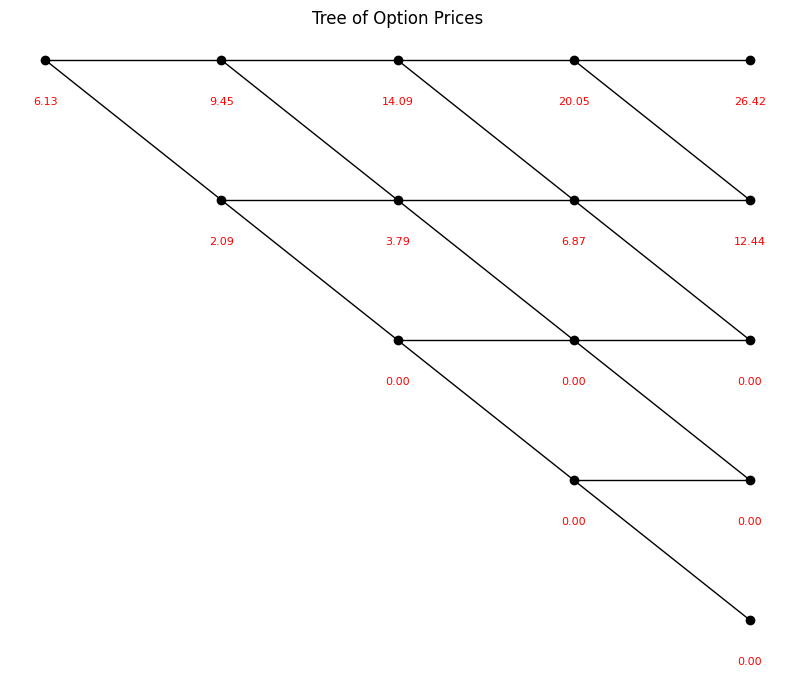

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the price matrix
price_matrix = np.array([
    [6.13447, 9.44515, 14.08895, 20.05391, 26.42077],
    [0.00000, 2.09274, 3.79066, 6.86618, 12.43699],
    [0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
    [0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
    [0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
])

def draw_tree(price_matrix):
    rows, cols = price_matrix.shape

    # Calculate the x-offset to center the first node
    middle_x = (cols - 1) / 2  # Middle of the last column
    x_offset = middle_x  # Shift the first column horizontally to align with the middle

    # Generate positions for all nodes (including zeros)
    node_positions = {}
    for col in range(cols):
        for row in range(col + 1):
            value = price_matrix[row, col]
            x = col + x_offset - col / 2  # Adjust x-coordinate for alignment
            y = row  # Vertical position based on row index
            node_positions[(row, col)] = (x, y, value)

    # Generate edges between connected nodes
    edges = []
    for col in range(cols - 1):  # Iterate over columns for connecting nodes
        for row in range(col + 1):
            # Connect current node to its left child
            edges.append((node_positions[(row, col)], node_positions[(row, col + 1)]))
            # Connect current node to its right child
            edges.append((node_positions[(row, col)], node_positions[(row + 1, col + 1)]))

    # Plot the tree
    plt.figure(figsize=(10, 8))

    # Plot edges
    for edge in edges:
        (x0, y0, _), (x1, y1, _) = edge
        plt.plot([x0, x1], [y0, y1], 'k-', lw=1)  # Black lines for edges

    # Plot nodes and values (including zeros)
    for (x, y, value) in node_positions.values():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.3, f'{value:.2f}', ha='center', va='center', fontsize=8, color='red')  # Values in red

    # Finalize plot
    plt.title("Tree of Option Prices")
    plt.gca().invert_yaxis()  # Align y-axis top-to-bottom
    plt.axis('off')  # Turn off the axes for a clean look
    plt.show()

# Draw the tree
draw_tree(price_matrix)


In [27]:
import numpy as np

def binomial_special_matrix(a, n):
    # Create a grid of indices for powers
    rows, cols = np.triu_indices(n + 1)
    # Compute terms for (a + 1/a)^n
    terms = a ** ((cols - rows) + (np.sort(rows - cols)[::-1]))
    # Create an upper diagonal matrix
    matrix = np.zeros((n + 1,  n + 1))
    matrix[rows, cols] = terms

    return  matrix

a = 1.0604
n = 4

print("Special case (b = 1/a, Upper Diagonal Matrix):\n", binomial_special_matrix(a, n))

KeyboardInterrupt: 